# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [37]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [38]:
print(tf.__version__)

2.9.1


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [39]:
fullPath = os.path.abspath("./data" )
dataset = tf.keras.utils.get_file(None, fullPath, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.dirname(dataset)

In [40]:
os.listdir(dataset_dir)

['training-data.csv.bak',
 'new.ipynb',
 'text_classification_original.ipynb',
 'aclImdb',
 'README.MD',
 'aclImdb_v1.tar.gz',
 'AllDetails.csv',
 'text_classification.ipynb',
 'text_classification_dir_based_v3.ipynb',
 '.ipynb_checkpoints',
 'verification.csv',
 'training-data.csv',
 'data',
 'convert-csv-to-dirstructure.py']

In [41]:
train_dir = os.path.join(dataset_dir, 'data/train')
os.listdir(train_dir)

['AddCandidates',
 'API-Candidates',
 'One-ClickApply',
 'Interviews-Scheduling',
 'JobAdsAPI',
 'JobListPage',
 'Reporting',
 'JobAlerts',
 'MobileFieldRecruitingApps-(iOS&Android)',
 'APIWebhooks-Jobs&Positions',
 'PartnerPortal',
 'Tasks',
 'CandidatesAttachments',
 'APIWebhooks-ScreeningQuestions',
 'Inbox',
 'DocuSign',
 'Notifications-Email',
 'Tableau',
 'UserManagement',
 'RejectCandidate',
 'Silkroad',
 'ScreeningQuestions',
 'API-Users',
 'API-Authentication',
 'CareerSite',
 'Publisher',
 'SocialMediaShare',
 'Passwordrecoveryemails-Users',
 'SearchingandFilteringCandidates',
 'SmartRProfile',
 'JobPal',
 'Referrals',
 'Users&Roles-Permissions',
 'DeferCandidate',
 'API-Analytics',
 'LoginPage',
 'CandidateStatuses',
 'Website',
 'CRM',
 'API-Marketplace',
 'Mobster-MobileAPI',
 'GoogleTagManager',
 'CandidateOffers',
 'SmartPal',
 'SmartRDashboard',
 'JobPostingWizard',
 'API-Approvals',
 'SmartRApply',
 'EmailTemplates',
 'API-Offers',
 'AssessmentsV1',
 'HiringProcess-con

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [42]:
sample_file = os.path.join(train_dir, 'Interviews-Scheduling/1.txt')
with open(sample_file) as f:
  print(f.read())


*Where:*
In PROD
Company Name: Ent Credit Union
companyId (legacy): 148844567
companyId: 6151f3102831656907665feb
Integration: MSFT Calendar Integration
*What:*
See attached screen shots. In shot number 1, you can see that our recruiter has selected to view someone's schedule and availability is displaying. In shot number 2, you can see that when she selects a meeting room, the availability info for the manager goes away.
*Steps Taken to Replicate:*
1. Log in to the customer's account through SR admin
2. Refer to the the candidate profile and schedule an Interview
3. Select the user's schedule.
4. Choose the meeting room
5. The availability of the user's selected is wiped off.

Browser: Google Chrome
Version: Version 108.0.5359.94 (Official Build) (arm64)
Reason for Priority: P3
Date and Time Issue Occurred: 17.00 CEST



### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set).

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [43]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'data/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 974 files belonging to 115 classes.
Using 780 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [44]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'\n*+Where+:*\r\nIn PROD\r\nCompany Name:\xc2\xa0PublicisGroupe\r\ncompanyId (legacy): 111488791\r\ncompanyId: 58822766e4b0680b1154ae69\r\n\r\n*+What+:*\xc2\xa0Cannot upload a gif to templates because of 504 error occurring\r\n\r\n*+Steps Taken to Replicate+:*\xc2\xa0\r\n\r\n1. Signed in to\xc2\xa0PublicisGroupe as SR Support\r\n2.\xc2\xa0Clicked on Email Templates\r\n3. Went to template named "UK - CPI - Prodigious - General Signature"\r\n4.\xc2\xa0Deleted old branding and tried to add gif\r\n5. Received error\r\n\r\n\xc2\xa0\r\n\r\n*Ray ID:*\xc2\xa077265936a1d8bf24\r\n\r\n*+Date and Time Issue Occurred+:*\xc2\xa0Replicated November 30, 2022 21:35 CET\r\n\r\n*+User Expected Behavior+:*\xc2\xa0Users should be able to upload gifs without encountering 504 errors\r\n\r\n*+Reason for Priority:+*\xc2\xa0 It is impacting the customer from having a better experience with images in email templates'
Label 109
Review b'\n*Where:*\r\n\r\nIn PROD\r\n\r\nCompany Name: LinkedIn\r\n\r\nCompan

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section.

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [45]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to API-AIServices
Label 1 corresponds to API-Analytics


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [46]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'data/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 974 files belonging to 115 classes.
Using 194 files for validation.


In [47]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'data/validation',
    batch_size=batch_size)

Found 314 files belonging to 80 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [48]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [49]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [50]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [51]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [52]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"\nWhere: In Prod\r\nCompany Name: Sam Hannaway Demo\r\ncompanyId (legacy): 152547095\r\ncompanyId: 61d48149b5958829cadc67ad\r\n \r\nWhat: Alert appearing on page load randomly throughout system\r\n \r\nSteps Taken to Replicate:\r\n1. Login to FromKrakowToMars with the user account Jeremy Admin\r\n2. Navigate through the platform, this alert message flashes up randomly while loading pages.\r\n3. The pages are loading correctly.\r\n\r\nBrowser: Chrome Version 103.0.5060.114 (Official Build) (arm64)\r\n\r\nReason for Priority: P3 - usability not impacted \r\n\r\nDate and Time Issue Occurred: July 12 2022\r\n\r\nUser Expected Behavior: Alert shouldn't be appearing for no reason.\r\n\r\nSample: screenshot of the alert message.\r\n\r\nNote: tried to replicate on Mozilla, didn't see this alert.\r\nReported by the sales team who is seeing this alert while presenting demo to customers.", shape=(), dtype=string)
Label Unknown
Vectorized review (<tf.Tensor: shape=(1, 250), dtyp

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [53]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  acceptlanguage
 313 --->  know
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [54]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [55]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [56]:
embedding_dim = 16

In [57]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(115)]) #number of classes

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 115)               1955      
                                                                 
Total params: 161,971
Trainable params: 161,971
Non-trainable params: 0
________________________________________________

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [58]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [59]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
25/25 [==============================] - 1s 21ms/step - loss: 4.7353 - accuracy: 0.0667 - val_loss: 4.7297 - val_accuracy: 0.0309
Epoch 2/10
25/25 [==============================] - 0s 3ms/step - loss: 4.7113 - accuracy: 0.0808 - val_loss: 4.7112 - val_accuracy: 0.0670
Epoch 3/10
25/25 [==============================] - 0s 3ms/step - loss: 4.6816 - accuracy: 0.0872 - val_loss: 4.6865 - val_accuracy: 0.0773
Epoch 4/10
25/25 [==============================] - 0s 3ms/step - loss: 4.6412 - accuracy: 0.0821 - val_loss: 4.6536 - val_accuracy: 0.0722
Epoch 5/10
25/25 [==============================] - 0s 3ms/step - loss: 4.5892 - accuracy: 0.0756 - val_loss: 4.6126 - val_accuracy: 0.0722
Epoch 6/10
25/25 [==============================] - 0s 3ms/step - loss: 4.5272 - accuracy: 0.0756 - val_loss: 4.5662 - val_accuracy: 0.0722
Epoch 7/10
25/25 [==============================] - 0s 3ms/step - loss: 4.4567 - accuracy: 0.0731 - val_loss: 4.5182 - val_accuracy: 0.0722
Epoch 8/10
25/25 [=

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [60]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

10/10 [==============================] - 0s 2ms/step - loss: 4.9942 - accuracy: 0.0032
Loss:  4.994192123413086
Accuracy:  0.0031847134232521057


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [61]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

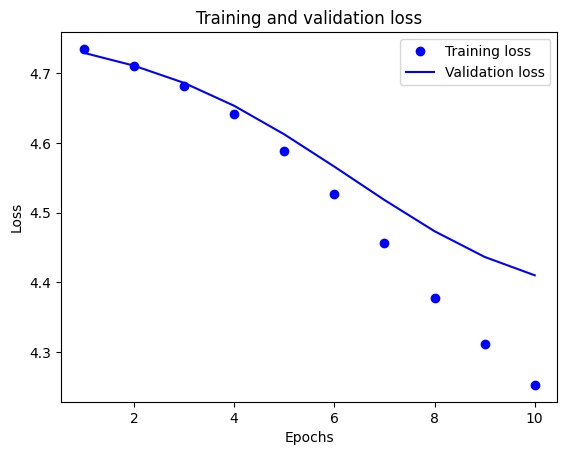

In [62]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

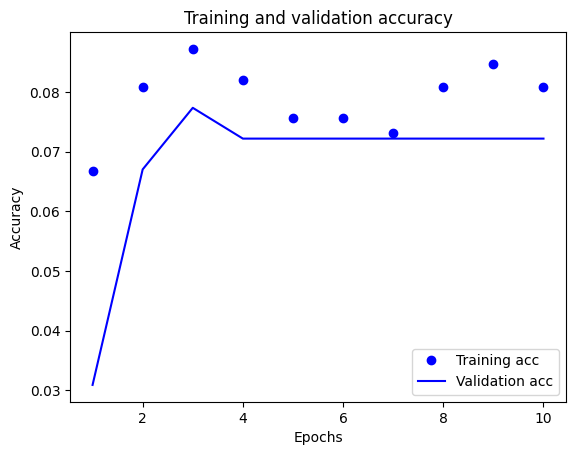

In [63]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [65]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

10/10 [==============================] - 0s 3ms/step - loss: 4.9942 - accuracy: 0.0032
0.0031847134232521057


/Users/karol.sendyka/private-workspace/pi-eye/venv2/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [67]:
examples = [
  'Multiple users are unable to login via SSO on their mobile device and in some cases via their computers as well.',
]

export_model.predict(examples)

1/1 [==============================] - 0s 35ms/step


array([[0.28964627, 0.14412959, 0.40725368, 0.19374676, 0.28418574,
        0.47990865, 0.39974874, 0.32539085, 0.5486726 , 0.24091192,
        0.34998775, 0.18956688, 0.4853809 , 0.33745542, 0.40360403,
        0.53388923, 0.25788584, 0.18675198, 0.26959965, 0.32851684,
        0.45487216, 0.35887203, 0.32757357, 0.4349659 , 0.28061163,
        0.3290115 , 0.5359107 , 0.8471478 , 0.6666062 , 0.33840984,
        0.50170285, 0.56754863, 0.3035394 , 0.2915542 , 0.35046256,
        0.47087237, 0.36903235, 0.45455107, 0.24153054, 0.38792932,
        0.21412916, 0.2200925 , 0.23223503, 0.1983756 , 0.4644676 ,
        0.534983  , 0.559944  , 0.64819914, 0.5895977 , 0.25119704,
        0.37763226, 0.25126627, 0.27318507, 0.47177094, 0.6724272 ,
        0.5569939 , 0.40481922, 0.3374064 , 0.45149592, 0.39629877,
        0.51307863, 0.35230583, 0.42965946, 0.31192517, 0.34197977,
        0.40936255, 0.2640426 , 0.4143023 , 0.48073044, 0.3160173 ,
        0.62736255, 0.36276206, 0.6739206 , 0.16

In [69]:
raw_train_ds.class_names[108]

'Tasks'

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python.

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier.

## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, check out the [Text classification guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.
